In [1]:
import os
import pandas as pd 
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic' # 폰트 변경
plt.rcParams['axes.unicode_minus'] = False # 축 값 마이너스 깨짐 해결
import numpy as np
from torch.nn import Transformer
from torch import nn
import torch
import math
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import mean_absolute_percentage_error ,mean_squared_error

In [2]:
#path = '~/workplace/datas/energy/'
path = '~/Desktop/workplace/datas/energy/'

In [3]:
train_df = pd.read_csv(path + 'encoded_train_df.csv', index_col=0)
test_df = pd.read_csv(path + 'encoded_test_df.csv', index_col=0)

In [4]:
train_df

,Year,Month,Day,Hour,기온(°C),풍속(m/s),습도(%),현지기압(hPa),지면온도(°C),강수량(mm),적설(cm),일조(hr),일사(MJ/m2),smp(원/kWh),발전량,휴일,5분전_현재수요(MW),1시간전_현재수요(MW),하루전_현재수요(MW),현재수요(MW)
일시,,,,,,,,,,,,,,,,,,,,
2018-01-02 01:05:00,2018,1,2,1,-2.955526,1.016140,67.514912,1015.174211,-3.007807,0.000000,0.022105,0.0,0.0,91.991667,5246.400000,0,58703.40,60556.60,58194.60,58466.40
2018-01-02 01:10:00,2018,1,2,1,-2.994211,1.009123,67.735088,1015.189474,-3.031404,0.000000,0.022105,0.0,0.0,91.723333,5246.400000,0,58466.40,60158.70,57830.60,58508.60
2018-01-02 01:15:00,2018,1,2,1,-3.032895,1.002105,67.955263,1015.204737,-3.055000,0.000000,0.022105,0.0,0.0,91.455000,10428.000000,0,58508.60,59842.30,57745.30,58209.90
2018-01-02 01:20:00,2018,1,2,1,-3.071579,0.995088,68.175439,1015.220000,-3.078596,0.000000,0.022105,0.0,0.0,91.186667,5731.200000,0,58209.90,59771.70,57329.60,58080.50
2018-01-02 01:25:00,2018,1,2,1,-3.110263,0.988070,68.395614,1015.235263,-3.102193,0.000000,0.022105,0.0,0.0,90.918333,6254.400000,0,58080.50,59393.60,57219.70,57942.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-12 23:35:00,2023,3,12,23,1.765000,5.063684,46.180702,1010.276667,1.134386,0.025482,0.011491,0.0,0.0,220.551667,39745.380277,0,60357.25,60754.29,58773.93,60235.18
2023-03-12 23:40:00,2023,3,12,23,1.720000,5.050526,46.045614,1010.288070,1.095088,0.029123,0.011930,0.0,0.0,223.523333,39745.380277,0,60235.18,60707.96,58326.83,60106.61
2023-03-12 23:45:00,2023,3,12,23,1.675000,5.037368,45.910526,1010.299474,1.055789,0.032763,0.012368,0.0,0.0,226.495000,39745.380277,0,60106.61,60673.42,58038.45,59725.49


In [5]:
X = train_df.iloc[:, :-1]
X.drop(['5분전_현재수요(MW)', '1시간전_현재수요(MW)'], axis=1, inplace=True)
y = train_df.iloc[:, -1]

In [6]:
X_test = test_df.iloc[:, :-1]
X_test.drop(['5분전_현재수요(MW)', '1시간전_현재수요(MW)'], axis=1, inplace=True)
y_test = test_df.iloc[:, -1]

In [7]:
X.shape, y.shape, X_test.shape, y_test.shape

((546035, 17), (546035,), (2016, 17), (2016,))

# mRMR

In [8]:
#mRMR
from mrmr import mrmr_classif, mrmr_regression
selected_features = mrmr_regression(X=X, y=y, K=20, return_scores=True)

100%|██████████| 17/17 [00:19<00:00,  1.13s/it]


In [9]:
selected_features

(['하루전_현재수요(MW)',
  'Hour',
  '휴일',
  '적설(cm)',
  'smp(원/kWh)',
  '풍속(m/s)',
  '습도(%)',
  '일조(hr)',
  '발전량',
  '현지기압(hPa)',
  'Year',
  'Month',
  '일사(MJ/m2)',
  '기온(°C)',
  'Day',
  '지면온도(°C)',
  '강수량(mm)'],
 Year              2860.884629
 Month             1682.232189
 Day                151.384261
 Hour             66369.451132
 기온(°C)            4006.375704
 풍속(m/s)          22691.984785
 습도(%)            25356.101253
 현지기압(hPa)         3340.531774
 지면온도(°C)           871.292241
 강수량(mm)             44.465668
 적설(cm)           42858.655050
 일조(hr)           12527.003168
 일사(MJ/m2)         6372.065627
 smp(원/kWh)       43467.539457
 발전량               8353.840599
 휴일               27191.463755
 하루전_현재수요(MW)    783073.146561
 dtype: float64,
                   Year     Month       Day      Hour    기온(°C)   풍속(m/s)  \
 Year          0.001000  0.001000  0.001000  0.001000  0.001000  0.020105   
 Month         0.099795  0.001000  0.001000  0.001000  0.001000  0.139199   
 Day           0

In [10]:
mrmr = []

for i , j in enumerate(selected_features[0]):
    mrmr.append([(i+1),j])

In [11]:
mrmr = pd.DataFrame(mrmr, columns=['rank', 'features'])

In [12]:
mrmr

,rank,features
0,1,하루전_현재수요(MW)
1,2,Hour
2,3,휴일
3,4,적설(cm)
4,5,smp(원/kWh)
5,6,풍속(m/s)
6,7,습도(%)
7,8,일조(hr)
8,9,발전량
9,10,현지기압(hPa)


# SAHP

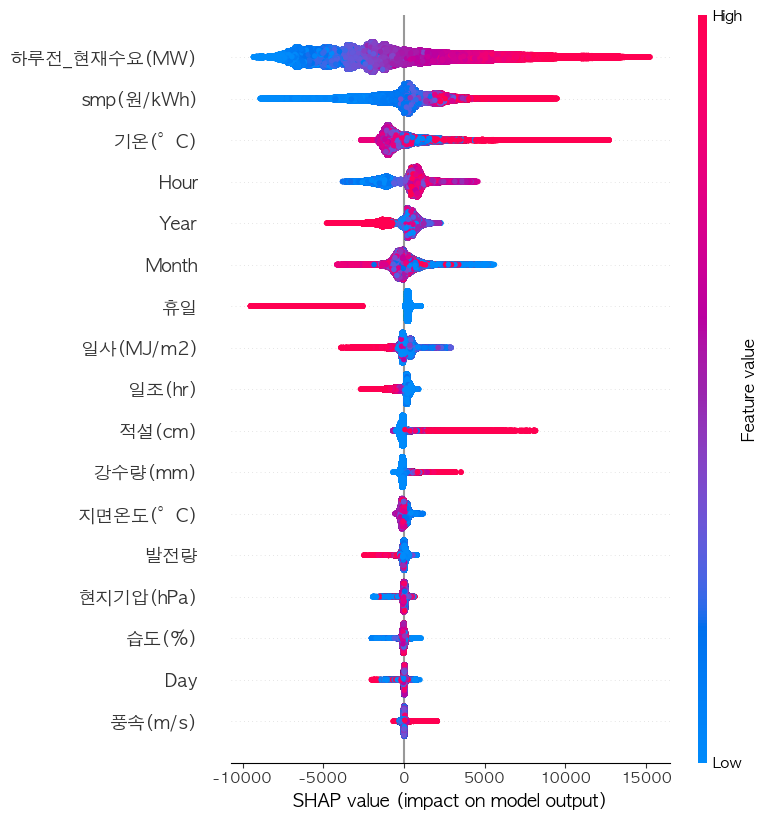

In [13]:
import shap
import lightgbm as lgb

model = lgb.LGBMRegressor()
model.fit(X, y)


explainer = shap.Explainer(model)



shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

In [14]:
import numpy as np

# Calculate mean absolute SHAP values
mean_shap_values = np.mean(np.abs(shap_values), axis=0)

# Print feature importance
shap = []
for feature_name, mean_value in zip(X.keys(), mean_shap_values):
    print(f"{feature_name}: {mean_value}")
    shap.append([mean_value,feature_name])


Year: 719.313814712678
Month: 542.650949205574
Day: 77.04384260414355
Hour: 1000.9766935109452
기온(°C): 1106.7750976267416
풍속(m/s): 76.86485513611495
습도(%): 79.58238694273108
현지기압(hPa): 84.53280097790875
지면온도(°C): 153.71255804031412
강수량(mm): 180.35373807191087
적설(cm): 237.76292465430305
일조(hr): 346.44804487159405
일사(MJ/m2): 362.93868823402585
smp(원/kWh): 1626.1287881065525
발전량: 106.7906934845639
휴일: 471.5528616848872
하루전_현재수요(MW): 3929.752665554796


In [15]:
shap = pd.DataFrame(shap, columns=['value', 'features'])

In [16]:
shap.sort_values('value', ascending=False, inplace=True)

In [17]:
shap['rank'] = [i for i in range(1, len(shap) + 1)]

In [18]:
shap.rename(columns={'rank':'shap_rank'}, inplace=True)

In [19]:
mrmr.set_index(['features'], inplace=True)
shap.set_index(['features'], inplace=True)

In [20]:
shap

,value,shap_rank
features,,
하루전_현재수요(MW),3929.752666,1
smp(원/kWh),1626.128788,2
기온(°C),1106.775098,3
Hour,1000.976694,4
Year,719.313815,5
Month,542.650949,6
휴일,471.552862,7
일사(MJ/m2),362.938688,8
일조(hr),346.448045,9


In [21]:
merge_df = pd.merge(mrmr, shap, left_index=True, right_index=True)
merge_df.drop('value', axis=1, inplace=True)

In [22]:
merge_df['sum'] = (merge_df['rank'] ** 2) + (merge_df['shap_rank'] **2)

In [23]:
merge_df.sort_values('sum', ascending=True, inplace=True)

In [24]:
merge_df

,rank,shap_rank,sum
features,,,
하루전_현재수요(MW),1,1,2
Hour,2,4,20
smp(원/kWh),5,2,29
휴일,3,7,58
적설(cm),4,10,116
일조(hr),8,9,145
Year,11,5,146
Month,12,6,180
기온(°C),14,3,205


# 인덱스 순위

In [25]:
merge_df.index

Index(['하루전_현재수요(MW)', 'Hour', 'smp(원/kWh)', '휴일', '적설(cm)', '일조(hr)', 'Year',
       'Month', '기온(°C)', '일사(MJ/m2)', '발전량', '습도(%)', '현지기압(hPa)', '풍속(m/s)',
       '지면온도(°C)', '강수량(mm)', 'Day'],
      dtype='object', name='features')

In [26]:
X = X[merge_df.index]
X

,하루전_현재수요(MW),Hour,smp(원/kWh),휴일,적설(cm),일조(hr),Year,Month,기온(°C),일사(MJ/m2),발전량,습도(%),현지기압(hPa),풍속(m/s),지면온도(°C),강수량(mm),Day
일시,,,,,,,,,,,,,,,,,
2018-01-02 01:05:00,58194.60,1,91.991667,0,0.022105,0.0,2018,1,-2.955526,0.0,5246.400000,67.514912,1015.174211,1.016140,-3.007807,0.000000,2
2018-01-02 01:10:00,57830.60,1,91.723333,0,0.022105,0.0,2018,1,-2.994211,0.0,5246.400000,67.735088,1015.189474,1.009123,-3.031404,0.000000,2
2018-01-02 01:15:00,57745.30,1,91.455000,0,0.022105,0.0,2018,1,-3.032895,0.0,10428.000000,67.955263,1015.204737,1.002105,-3.055000,0.000000,2
2018-01-02 01:20:00,57329.60,1,91.186667,0,0.022105,0.0,2018,1,-3.071579,0.0,5731.200000,68.175439,1015.220000,0.995088,-3.078596,0.000000,2
2018-01-02 01:25:00,57219.70,1,90.918333,0,0.022105,0.0,2018,1,-3.110263,0.0,6254.400000,68.395614,1015.235263,0.988070,-3.102193,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-12 23:35:00,58773.93,23,220.551667,0,0.011491,0.0,2023,3,1.765000,0.0,39745.380277,46.180702,1010.276667,5.063684,1.134386,0.025482,12
2023-03-12 23:40:00,58326.83,23,223.523333,0,0.011930,0.0,2023,3,1.720000,0.0,39745.380277,46.045614,1010.288070,5.050526,1.095088,0.029123,12
2023-03-12 23:45:00,58038.45,23,226.495000,0,0.012368,0.0,2023,3,1.675000,0.0,39745.380277,45.910526,1010.299474,5.037368,1.055789,0.032763,12


In [27]:
X_test = X_test.reindex(columns=merge_df.index)

X_test = X_test.iloc[:, :]

In [28]:
X.shape, X_test.shape, y.shape, y_test.shape

((546035, 17), (2016, 17), (546035,), (2016,))

In [29]:
from flaml import AutoML
from flaml.ml import sklearn_metric_loss_score

model = AutoML()


model.fit(X, y, task='regression',
          time_budget=7200,
          metric='mse',
          log_file_name='electric.log')

print(model._best_estimator)
print(model.best_result)
print(model.best_config)

[flaml.automl: 07-20 12:50:30] {2600} INFO - task = regression
[flaml.automl: 07-20 12:50:30] {2602} INFO - Data split method: uniform
[flaml.automl: 07-20 12:50:30] {2605} INFO - Evaluation method: holdout
[flaml.automl: 07-20 12:50:30] {2727} INFO - Minimizing error metric: rmse
[flaml.automl: 07-20 12:50:30] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 07-20 12:50:30] {3164} INFO - iteration 0, current learner lgbm
[flaml.automl: 07-20 12:50:30] {3297} INFO - Estimated sufficient time budget=9158s. Estimated necessary time budget=78s.
[flaml.automl: 07-20 12:50:30] {3344} INFO -  at 1.2s,	estimator lgbm's best error=7375.7024,	best estimator lgbm's best error=7375.7024
[flaml.automl: 07-20 12:50:30] {3164} INFO - iteration 1, current learner lgbm
[flaml.automl: 07-20 12:50:30] {3344} INFO -  at 1.2s,	estimator lgbm's best error=7375.7024,	best estimator lgbm's best error=7375.7024
[flaml.automl:

lgbm
{'pred_time': 0.002503814177498801, 'wall_clock_time': 5918.719949007034, 'metric_for_logging': {'pred_time': 0.002503814177498801}, 'val_loss': 318.64648040369565, 'training_iteration': 1, 'config': {'n_estimators': 32767, 'num_leaves': 1190, 'min_child_samples': 8, 'learning_rate': 0.01715339383561772, 'log_max_bin': 6, 'colsample_bytree': 0.3680375659422079, 'reg_alpha': 0.002093816437589562, 'reg_lambda': 0.02378621744861929, 'FLAML_sample_size': 491431}, 'config/n_estimators': 32767, 'config/num_leaves': 1190, 'config/min_child_samples': 8, 'config/learning_rate': 0.01715339383561772, 'config/log_max_bin': 6, 'config/colsample_bytree': 0.3680375659422079, 'config/reg_alpha': 0.002093816437589562, 'config/reg_lambda': 0.02378621744861929, 'config/FLAML_sample_size': 491431, 'experiment_tag': 'exp', 'time_total_s': 2831.9757471084595}
{'n_estimators': 32767, 'num_leaves': 1190, 'min_child_samples': 8, 'learning_rate': 0.01715339383561772, 'log_max_bin': 6, 'colsample_bytree': 0

In [32]:
y_pred = model.predict(X_test)

sklearn_metric_loss_score(metric_name='mape', y_predict=y_pred, y_true=y_test )

0.055834549535466384

In [ ]:
''' ALL
lgbm
{'pred_time': 0.002503814177498801, 'wall_clock_time': 5918.719949007034, 'metric_for_logging': {'pred_time': 0.002503814177498801}, 'val_loss': 318.64648040369565, 'training_iteration': 1, 'config': {'n_estimators': 32767, 'num_leaves': 1190, 'min_child_samples': 8, 'learning_rate': 0.01715339383561772, 'log_max_bin': 6, 'colsample_bytree': 0.3680375659422079, 'reg_alpha': 0.002093816437589562, 'reg_lambda': 0.02378621744861929, 'FLAML_sample_size': 491431}, 'config/n_estimators': 32767, 'config/num_leaves': 1190, 'config/min_child_samples': 8, 'config/learning_rate': 0.01715339383561772, 'config/log_max_bin': 6, 'config/colsample_bytree': 0.3680375659422079, 'config/reg_alpha': 0.002093816437589562, 'config/reg_lambda': 0.02378621744861929, 'config/FLAML_sample_size': 491431, 'experiment_tag': 'exp', 'time_total_s': 2831.9757471084595}
{'n_estimators': 32767, 'num_leaves': 1190, 'min_child_samples': 8, 'learning_rate': 0.01715339383561772, 'log_max_bin': 6, 'colsample_bytree': 0.3680375659422079, 'reg_alpha': 0.002093816437589562, 'reg_lambda': 0.02378621744861929, 'FLAML_sample_size': 491431}
'''


